# Analisis Klasifikasi Berita dengan Topik Modelling
## Menggunakan Naive Bayes dan SVM

Proyek ini melakukan analisis klasifikasi berita dengan:
1. Ekstraksi fitur menggunakan TF-IDF dan LDA (Latent Dirichlet Allocation)
2. Classifier Naive Bayes dan SVM
3. Evaluasi performa dengan confusion matrix dan cross validation

**Dataset**: Berita.csv (1500 berita dengan 4 kategori: Ekonomi, Olahraga, Nasional, Internasional)


In [29]:
import sys, subprocess
print("Python executable:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk", "gensim", "Sastrawi", "scikit-learn", "matplotlib", "seaborn", "pandas", "numpy"])

Python executable: c:\Users\LX\AppData\Local\Programs\Python\Python311\python.exe


0

In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries untuk preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Import libraries untuk topic modelling
from gensim import corpora, models
from gensim.models import LdaModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# Import libraries untuk preprocessing teks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK data berhasil diunduh")
except:
    print("Gagal mengunduh NLTK data")

print("Semua library berhasil diimport!")


NLTK data berhasil diunduh
Semua library berhasil diimport!


In [32]:
# Cell 2: Definisi Class KlasifikasiBerita
class KlasifikasiBerita:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.tfidf_vectorizer = None
        self.lda_model = None
        self.nb_model = None
        self.svm_model = None
        self.label_encoder = LabelEncoder()
        
        # Inisialisasi stemmer untuk bahasa Indonesia
        self.factory = StemmerFactory()
        self.stemmer = self.factory.create_stemmer()
        
        # Stopwords bahasa Indonesia
        self.indonesian_stopwords = set([
            'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'dengan', 'untuk', 'pada',
            'adalah', 'akan', 'telah', 'sudah', 'belum', 'tidak', 'bukan', 'juga',
            'atau', 'namun', 'tetapi', 'karena', 'jika', 'ketika', 'sebagai', 'dalam',
            'oleh', 'dengan', 'serta', 'atau', 'namun', 'tetapi', 'karena', 'jika',
            'ketika', 'sebagai', 'dalam', 'oleh', 'dengan', 'serta', 'bisa', 'dapat',
            'harus', 'perlu', 'mungkin', 'akan', 'sedang', 'sudah', 'telah', 'baru',
            'saja', 'hanya', 'bahkan', 'juga', 'juga', 'lagi', 'masih', 'tetap',
            'selalu', 'kadang', 'sering', 'biasa', 'umum', 'khusus', 'terutama'
        ])
    
    def load_data(self, file_path):
        """Load data dari CSV file"""
        print("Memuat data dari CSV...")
        self.data = pd.read_csv(file_path)
        print(f"Data berhasil dimuat: {len(self.data)} berita")
        print(f"Kategori: {self.data['kategori'].value_counts().to_dict()}")
        return self.data
    
    def preprocess_text(self, text):
        """Preprocessing teks untuk bahasa Indonesia"""
        if pd.isna(text):
            return ""
        
        # Konversi ke lowercase
        text = text.lower()
        
        # Hapus karakter khusus dan angka
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)
        
        # Hapus whitespace berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenisasi
        tokens = word_tokenize(text)
        
        # Hapus stopwords
        tokens = [token for token in tokens if token not in self.indonesian_stopwords]
        
        # Stemming
        tokens = [self.stemmer.stem(token) for token in tokens]
        
        # Hapus token yang terlalu pendek
        tokens = [token for token in tokens if len(token) > 2]
        
        return ' '.join(tokens)

print("Class KlasifikasiBerita berhasil didefinisikan!")


Class KlasifikasiBerita berhasil didefinisikan!


In [ ]:
# Cell 3: Metode untuk Persiapan Data dan Ekstraksi Fitur
def prepare_data(self):
    """Mempersiapkan data untuk training dan testing"""
    print("Memproses data...")
    
    # Preprocessing teks
    self.data['berita_processed'] = self.data['berita'].apply(self.preprocess_text)
    
    # Gabungkan judul dan berita
    self.data['text_combined'] = self.data['judul'] + ' ' + self.data['berita_processed']
    
    # Encode labels
    y = self.label_encoder.fit_transform(self.data['kategori'])
    
    # Split data
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.data['text_combined'], y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Data training: {len(self.X_train)}")
    print(f"Data testing: {len(self.X_test)}")

def extract_tfidf_features(self):
    """Ekstraksi fitur menggunakan TF-IDF"""
    print("Ekstraksi fitur TF-IDF...")
    
    self.tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
    
    X_train_tfidf = self.tfidf_vectorizer.fit_transform(self.X_train)
    X_test_tfidf = self.tfidf_vectorizer.transform(self.X_test)
    
    return X_train_tfidf, X_test_tfidf

def extract_lda_features(self, num_topics=10):
    """Ekstraksi fitur menggunakan LDA (Latent Dirichlet Allocation)"""
    print(f"Ekstraksi fitur LDA dengan {num_topics} topik...")

    # Persiapan dokumen untuk LDA
    documents = [doc.split() for doc in self.X_train]

    # Buat dictionary dan corpus (bag-of-words)
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2, no_above=0.95)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Train LDA model
    self.lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )

    # Ekstraksi fitur LDA untuk training data
    X_train_lda = []
    for doc in documents:
        bow = dictionary.doc2bow(doc)
        topics = self.lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_probs = [prob for _, prob in topics]
        X_train_lda.append(topic_probs)

    # Ekstraksi fitur LDA untuk testing data
    X_test_lda = []
    test_documents = [doc.split() for doc in self.X_test]
    for doc in test_documents:
        bow = dictionary.doc2bow(doc)
        topics = self.lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_probs = [prob for _, prob in topics]
        X_test_lda.append(topic_probs)

    return np.array(X_train_lda), np.array(X_test_lda)

# Tambahkan method ke class
KlasifikasiBerita.prepare_data = prepare_data
KlasifikasiBerita.extract_tfidf_features = extract_tfidf_features
KlasifikasiBerita.extract_lda_features = extract_lda_features

print("Metode untuk persiapan data dan ekstraksi fitur berhasil ditambahkan!")


Metode untuk persiapan data dan ekstraksi fitur berhasil ditambahkan!


In [ ]:
# Cell 4: Metode untuk Training Classifier
def train_naive_bayes(self, X_train, X_test):
    """Training model Naive Bayes"""
    print("Training Naive Bayes...")
    
    self.nb_model = MultinomialNB(alpha=1.0)
    self.nb_model.fit(X_train, self.y_train)
    
    # Prediksi
    y_pred_nb = self.nb_model.predict(X_test)
    
    # Evaluasi
    accuracy_nb = accuracy_score(self.y_test, y_pred_nb)
    print(f"Akurasi Naive Bayes: {accuracy_nb:.4f}")
    
    return y_pred_nb, accuracy_nb

def train_svm(self, X_train, X_test):
    """Training model SVM"""
    print("Training SVM...")
    
    self.svm_model = SVC(kernel='linear', C=1.0, random_state=42)
    self.svm_model.fit(X_train, self.y_train)
    
    # Prediksi
    y_pred_svm = self.svm_model.predict(X_test)
    
    # Evaluasi
    accuracy_svm = accuracy_score(self.y_test, y_pred_svm)
    print(f"Akurasi SVM: {accuracy_svm:.4f}")
    
    return y_pred_svm, accuracy_svm

def show_lda_topics(self):
    """Menampilkan topik-topik yang ditemukan oleh LDA"""
    if self.lda_model is None:
        print("LDA model belum di-train!")
        return
    
    print("\n=== TOPIK-TOPIK LDA ===")
    topics = self.lda_model.print_topics(num_words=10)
    for idx, topic in enumerate(topics):
        print(f"Topik {idx + 1}: {topic}")

# Tambahkan method ke class
KlasifikasiBerita.train_naive_bayes = train_naive_bayes
KlasifikasiBerita.train_svm = train_svm
KlasifikasiBerita.show_lda_topics = show_lda_topics

print("Metode untuk training classifier berhasil ditambahkan!")


Metode untuk training classifier berhasil ditambahkan!


In [35]:
# Cell 5: Metode untuk Evaluasi Model
def evaluate_models(self, y_pred_nb, y_pred_svm):
    """Evaluasi dan perbandingan model"""
    print("\n=== EVALUASI MODEL ===")
    
    # Classification Report
    print("\n--- Naive Bayes ---")
    print(classification_report(self.y_test, y_pred_nb, 
                              target_names=self.label_encoder.classes_))
    
    print("\n--- SVM ---")
    print(classification_report(self.y_test, y_pred_svm, 
                              target_names=self.label_encoder.classes_))
    
    # Confusion Matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Naive Bayes Confusion Matrix
    cm_nb = confusion_matrix(self.y_test, y_pred_nb)
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix - Naive Bayes')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_xticklabels(self.label_encoder.classes_, rotation=45)
    ax1.set_yticklabels(self.label_encoder.classes_, rotation=0)
    
    # SVM Confusion Matrix
    cm_svm = confusion_matrix(self.y_test, y_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=ax2)
    ax2.set_title('Confusion Matrix - SVM')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_xticklabels(self.label_encoder.classes_, rotation=45)
    ax2.set_yticklabels(self.label_encoder.classes_, rotation=0)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def cross_validation_evaluation(self, X_train, X_test):
    """Evaluasi dengan cross validation"""
    print("\n=== CROSS VALIDATION ===")
    
    # Cross validation untuk Naive Bayes
    nb_cv_scores = cross_val_score(MultinomialNB(), X_train, self.y_train, cv=5)
    print(f"Naive Bayes CV Scores: {nb_cv_scores}")
    print(f"Naive Bayes CV Mean: {nb_cv_scores.mean():.4f} (+/- {nb_cv_scores.std() * 2:.4f})")
    
    # Cross validation untuk SVM
    svm_cv_scores = cross_val_score(SVC(kernel='linear', C=1.0), X_train, self.y_train, cv=5)
    print(f"SVM CV Scores: {svm_cv_scores}")
    print(f"SVM CV Mean: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std() * 2:.4f})")

# Tambahkan method ke class
KlasifikasiBerita.evaluate_models = evaluate_models
KlasifikasiBerita.cross_validation_evaluation = cross_validation_evaluation

print("Metode untuk evaluasi model berhasil ditambahkan!")


Metode untuk evaluasi model berhasil ditambahkan!


## 1. Load dan Eksplorasi Data


In [36]:
# Cell 6: Load dan Eksplorasi Data
# Inisialisasi classifier
classifier = KlasifikasiBerita()

# Load data
data = classifier.load_data('Berita.csv')

# Tampilkan informasi dasar tentang data
print("\n=== INFORMASI DATA ===")
print(f"Total berita: {len(data)}")
print(f"Kolom: {list(data.columns)}")
print(f"Kategori unik: {data['kategori'].unique()}")

# Tampilkan distribusi kategori
print("\n=== DISTRIBUSI KATEGORI ===")
print(data['kategori'].value_counts())

# Tampilkan contoh data
print("\n=== CONTOH DATA ===")
print(data[['judul', 'kategori']].head())


Memuat data dari CSV...
Data berhasil dimuat: 1500 berita
Kategori: {'Ekonomi': 375, 'Olahraga': 375, 'Nasional': 375, 'Internasional': 375}

=== INFORMASI DATA ===
Total berita: 1500
Kolom: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link']
Kategori unik: ['Ekonomi' 'Olahraga' 'Nasional' 'Internasional']

=== DISTRIBUSI KATEGORI ===
kategori
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64

=== CONTOH DATA ===
                                               judul kategori
0  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...  Ekonomi
1  PT SIER Beri Penghargaan untuk 50 Tenant Terba...  Ekonomi
2  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...  Ekonomi
3  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...  Ekonomi
4  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...  Ekonomi


## 2. Preprocessing Data


In [37]:
# Cell 7: Preprocessing Data
# Persiapan data untuk training dan testing
classifier.prepare_data()

# Tampilkan contoh teks yang sudah diproses
print("\n=== CONTOH TEKS YANG SUDAH DIPROSES ===")
for i in range(3):
    print(f"\nBerita {i+1}:")
    print(f"Judul asli: {data['judul'].iloc[i]}")
    print(f"Berita asli (100 karakter pertama): {data['berita'].iloc[i][:100]}...")
    print(f"Berita yang diproses (100 karakter pertama): {classifier.data['berita_processed'].iloc[i][:100]}...")
    print(f"Kategori: {data['kategori'].iloc[i]}")


Memproses data...
Data training: 1200
Data testing: 300

=== CONTOH TEKS YANG SUDAH DIPROSES ===

Berita 1:
Judul asli: Airlangga Harap Kenaikan UMP Tingkatkan Daya Beli Masyarakat Menengah
Berita asli (100 karakter pertama): Menteri Koordinator (Menko) Bidang Perekonomian Airlangga Hartarto berharap kenaikan upah minimum pr...
Berita yang diproses (100 karakter pertama): menteri koordinator menko bidang ekonomi airlangga hartarto harap naik upah minimum provinsi ump bes...
Kategori: Ekonomi

Berita 2:
Judul asli: PT SIER Beri Penghargaan untuk 50 Tenant Terbaik di HUT ke-50
Berita asli (100 karakter pertama): Dalam rangka memeriahkan hari jadi ke-50, PT Surabaya Industrial Estate Rungkut (PT SIER) menggelar ...
Berita yang diproses (100 karakter pertama): rangka riah hari jadi surabaya industrial estate rungkut sier gelar acara tajuk green industrial awa...
Kategori: Ekonomi

Berita 3:
Judul asli: Prabowo Bakal Bentuk Kementerian Penerimaan Negara, Dipimpin Anggito
Berita asli (100 ka

## 3. Ekstraksi Fitur TF-IDF


In [40]:
# Cell 8: Ekstraksi Fitur TF-IDF
# Ekstraksi fitur menggunakan TF-IDF
X_train_tfidf, X_test_tfidf = classifier.extract_tfidf_features()

print(f"Shape TF-IDF training: {X_train_tfidf.shape}")
print(f"Shape TF-IDF testing: {X_test_tfidf.shape}")
print(f"Jumlah fitur TF-IDF: {X_train_tfidf.shape[1]}")

# Tampilkan beberapa fitur penting
feature_names = classifier.tfidf_vectorizer.get_feature_names_out()
print(f"\nContoh fitur TF-IDF (10 pertama): {feature_names[:10]}")


Ekstraksi fitur TF-IDF...
Shape TF-IDF training: (1200, 5000)
Shape TF-IDF testing: (300, 5000)
Jumlah fitur TF-IDF: 5000

Contoh fitur TF-IDF (10 pertama): ['10' '12' '12 persen' '20' '2024' '2025' 'abbas' 'abdul' 'abdul karim'
 'abrasi']


## 4. Ekstraksi Fitur LDA (Topic Modelling)


In [6]:
# Cell 9: Ekstraksi Fitur LDA
# Pastikan class dan objek classifier siap
try:
    KlasifikasiBerita
except NameError:
    from klasifikasi_berita import KlasifikasiBerita

try:
    classifier
except NameError:
    classifier = KlasifikasiBerita()
    data = classifier.load_data('Berita.csv')
    classifier.prepare_data()

# Ekstraksi fitur menggunakan LDA dengan 10 topik
X_train_lda, X_test_lda = classifier.extract_lda_features(num_topics=10)

print(f"Shape LDA training: {X_train_lda.shape}")
print(f"Shape LDA testing: {X_test_lda.shape}")
print(f"Jumlah topik LDA: {X_train_lda.shape[1]}")

# Tampilkan topik-topik yang ditemukan
classifier.show_lda_topics()


Memuat data dari CSV...
Data berhasil dimuat: 1500 berita
Kategori: {'Ekonomi': 375, 'Olahraga': 375, 'Nasional': 375, 'Internasional': 375}
Memproses data...
Data training: 1200
Data testing: 300
Ekstraksi fitur LDA dengan 10 topik...
Shape LDA training: (1200, 10)
Shape LDA testing: (300, 10)
Jumlah topik LDA: 10

=== TOPIK-TOPIK LDA ===
Topik 1: (0, '0.017*"persen" + 0.009*"jadi" + 0.009*"ppn" + 0.009*"naik" + 0.009*"perintah" + 0.008*"kata" + 0.008*"menteri" + 0.008*"harga" + 0.008*"besar" + 0.007*"tahun"')
Topik 2: (1, '0.012*"kata" + 0.010*"sebut" + 0.010*"laku" + 0.009*"ada" + 0.009*"jadi" + 0.008*"orang" + 0.007*"korban" + 0.007*"duga" + 0.006*"kasus" + 0.005*"polisi"')
Topik 3: (2, '0.019*"main" + 0.015*"indonesia" + 0.012*"piala" + 0.011*"gol" + 0.011*"timnas" + 0.010*"dua" + 0.009*"menit" + 0.008*"jadi" + 0.008*"laga" + 0.008*"poin"')
Topik 4: (3, '0.040*"laut" + 0.029*"pagar" + 0.015*"ada" + 0.012*"tangerang" + 0.011*"sebut" + 0.011*"menteri" + 0.010*"milik" + 0.010*"kata" 

## 5. Klasifikasi dengan TF-IDF Features


=== KLASIFIKASI DENGAN TF-IDF FEATURES ===
Training Naive Bayes...
Akurasi Naive Bayes: 0.9400
Training SVM...
Akurasi SVM: 0.9567

=== EVALUASI MODEL ===

--- Naive Bayes ---
               precision    recall  f1-score   support

      Ekonomi       0.84      0.97      0.90        75
Internasional       0.99      0.99      0.99        75
     Nasional       0.97      0.80      0.88        75
     Olahraga       0.99      1.00      0.99        75

     accuracy                           0.94       300
    macro avg       0.95      0.94      0.94       300
 weighted avg       0.95      0.94      0.94       300


--- SVM ---
               precision    recall  f1-score   support

      Ekonomi       0.89      0.97      0.93        75
Internasional       0.99      0.99      0.99        75
     Nasional       0.97      0.87      0.92        75
     Olahraga       0.99      1.00      0.99        75

     accuracy                           0.96       300
    macro avg       0.96      0.96  

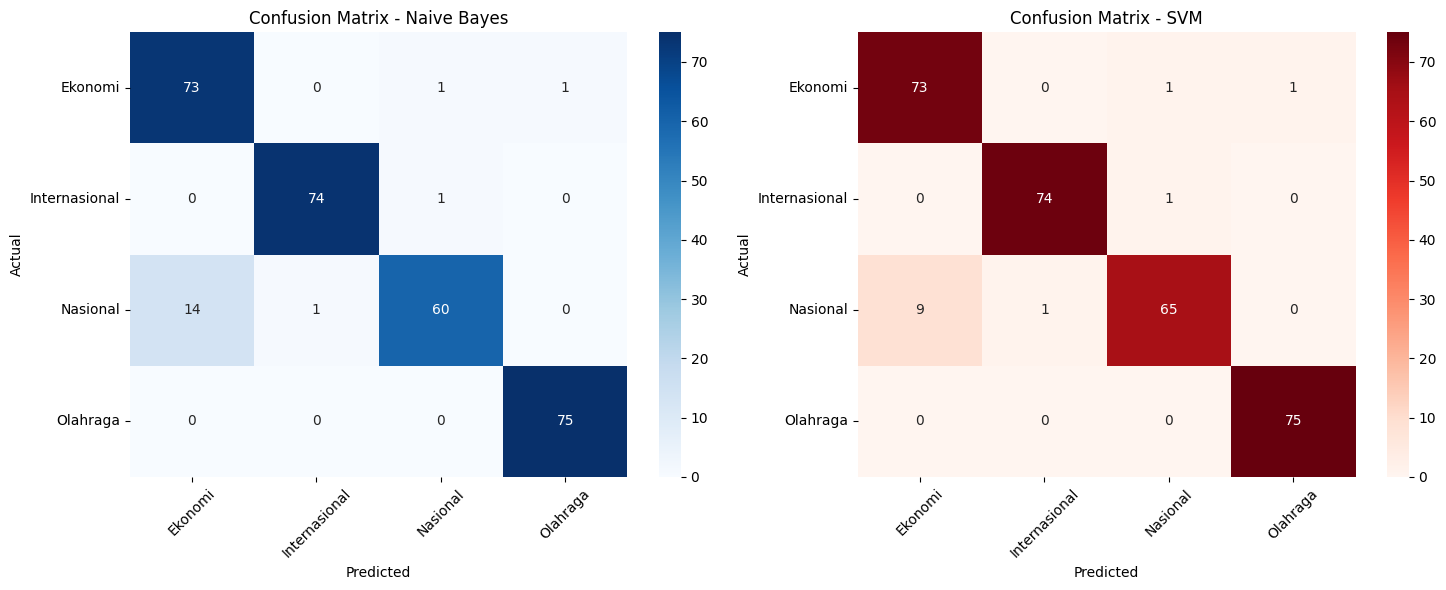


=== CROSS VALIDATION ===
Naive Bayes CV Scores: [0.9375     0.94583333 0.96666667 0.9625     0.93333333]
Naive Bayes CV Mean: 0.9492 (+/- 0.0266)
SVM CV Scores: [0.93333333 0.9625     0.95       0.97083333 0.92916667]
SVM CV Mean: 0.9492 (+/- 0.0322)


In [42]:
# Cell 10: Training dan Evaluasi dengan TF-IDF Features
print("=== KLASIFIKASI DENGAN TF-IDF FEATURES ===")

# Training Naive Bayes dengan TF-IDF
y_pred_nb_tfidf, acc_nb_tfidf = classifier.train_naive_bayes(X_train_tfidf, X_test_tfidf)

# Training SVM dengan TF-IDF
y_pred_svm_tfidf, acc_svm_tfidf = classifier.train_svm(X_train_tfidf, X_test_tfidf)

# Evaluasi model TF-IDF
classifier.evaluate_models(y_pred_nb_tfidf, y_pred_svm_tfidf)

# Cross validation untuk TF-IDF
classifier.cross_validation_evaluation(X_train_tfidf, X_test_tfidf)


## 6. Klasifikasi dengan LDA Features


=== KLASIFIKASI DENGAN LDA FEATURES ===
Training Naive Bayes...
Akurasi Naive Bayes: 0.8700
Training SVM...
Akurasi SVM: 0.8433

=== EVALUASI MODEL ===

--- Naive Bayes ---
               precision    recall  f1-score   support

      Ekonomi       0.78      0.92      0.85        75
Internasional       0.89      0.91      0.90        75
     Nasional       0.81      0.67      0.73        75
     Olahraga       1.00      0.99      0.99        75

     accuracy                           0.87       300
    macro avg       0.87      0.87      0.87       300
 weighted avg       0.87      0.87      0.87       300


--- SVM ---
               precision    recall  f1-score   support

      Ekonomi       0.78      0.92      0.85        75
Internasional       0.87      0.81      0.84        75
     Nasional       0.72      0.65      0.69        75
     Olahraga       1.00      0.99      0.99        75

     accuracy                           0.84       300
    macro avg       0.84      0.84     

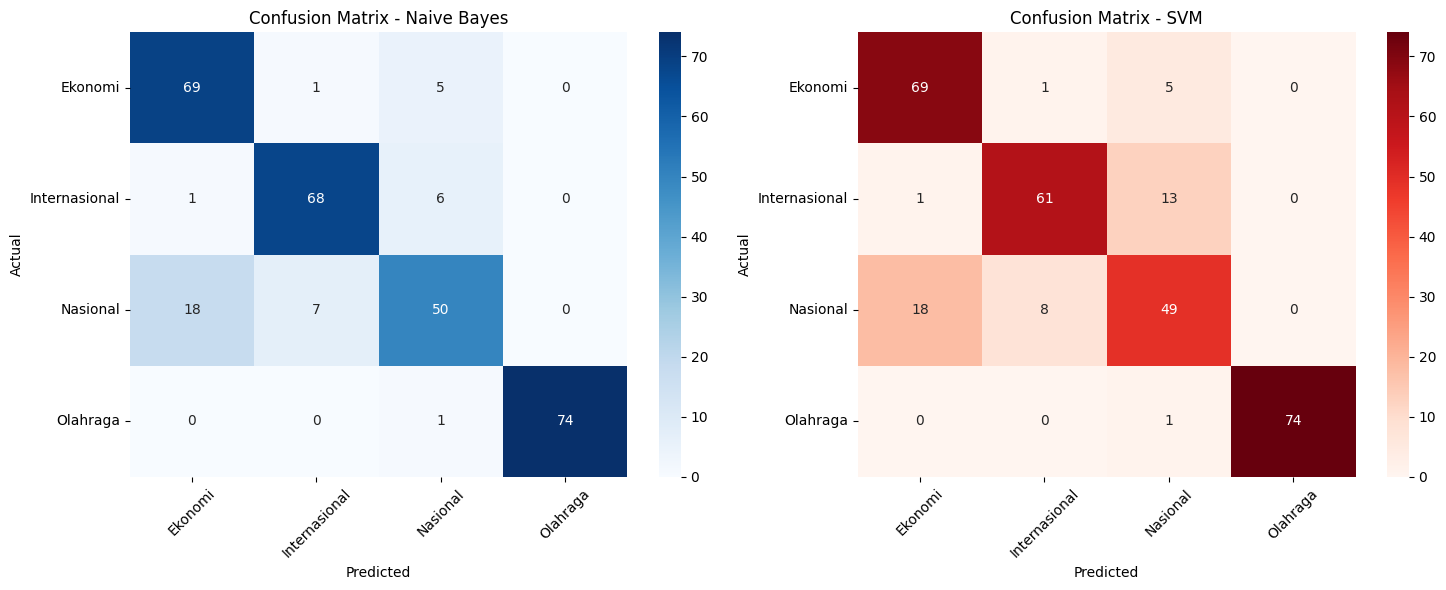


=== CROSS VALIDATION ===
Naive Bayes CV Scores: [0.84166667 0.80416667 0.825      0.82083333 0.80833333]
Naive Bayes CV Mean: 0.8200 (+/- 0.0266)
SVM CV Scores: [0.79583333 0.775      0.83333333 0.775      0.7875    ]
SVM CV Mean: 0.7933 (+/- 0.0430)


In [7]:
# Cell 11: Training dan Evaluasi dengan LDA Features
print("=== KLASIFIKASI DENGAN LDA FEATURES ===")

# Pastikan fitur LDA sudah diekstraksi
try:
    X_train_lda
    X_test_lda
except NameError:
    X_train_lda, X_test_lda = classifier.extract_lda_features(num_topics=10)
    # Opsional: tampilkan topik
    classifier.show_lda_topics()

# Training Naive Bayes dengan LDA
y_pred_nb_lda, acc_nb_lda = classifier.train_naive_bayes(X_train_lda, X_test_lda)

# Training SVM dengan LDA
y_pred_svm_lda, acc_svm_lda = classifier.train_svm(X_train_lda, X_test_lda)

# Evaluasi model LDA
classifier.evaluate_models(y_pred_nb_lda, y_pred_svm_lda)

# Cross validation untuk LDA
classifier.cross_validation_evaluation(X_train_lda, X_test_lda)


## 7. Ringkasan Hasil dan Perbandingan


=== RINGKASAN HASIL AKHIR ===
TF-IDF + Naive Bayes: 0.9400
TF-IDF + SVM: 0.9567
LDA + Naive Bayes: 0.8700
LDA + SVM: 0.8433


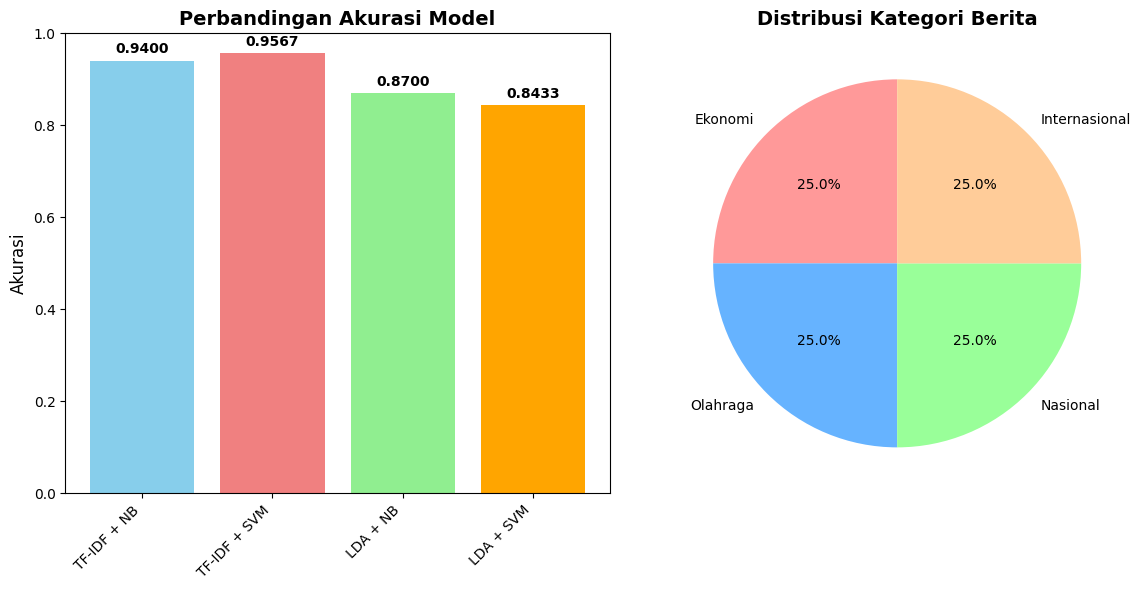


=== KESIMPULAN ===
Metode terbaik: TF-IDF + SVM dengan akurasi 0.9567
TF-IDF lebih efektif daripada LDA untuk ekstraksi fitur
Performa SVM dan Naive Bayes bervariasi tergantung metode ekstraksi fitur

Analisis selesai!


In [10]:
# Cell 12: Ringkasan Hasil dan Visualisasi Perbandingan
print("=== RINGKASAN HASIL AKHIR ===")

# Pastikan plotting siap
try:
    plt
except NameError:
    import matplotlib.pyplot as plt
try:
    sns
except NameError:
    import seaborn as sns

# Pastikan metrik TF-IDF tersedia; jika belum, hitung dulu
try:
    acc_nb_tfidf
    acc_svm_tfidf
except NameError:
    try:
        X_train_tfidf
        X_test_tfidf
    except NameError:
        X_train_tfidf, X_test_tfidf = classifier.extract_tfidf_features()
    y_pred_nb_tfidf, acc_nb_tfidf = classifier.train_naive_bayes(X_train_tfidf, X_test_tfidf)
    y_pred_svm_tfidf, acc_svm_tfidf = classifier.train_svm(X_train_tfidf, X_test_tfidf)

# Pastikan metrik LDA tersedia; jika belum, jalankan ekstraksi dan training LDA
try:
    acc_nb_lda
    acc_svm_lda
except NameError:
    try:
        X_train_lda
        X_test_lda
    except NameError:
        X_train_lda, X_test_lda = classifier.extract_lda_features(num_topics=10)
        classifier.show_lda_topics()
    y_pred_nb_lda, acc_nb_lda = classifier.train_naive_bayes(X_train_lda, X_test_lda)
    y_pred_svm_lda, acc_svm_lda = classifier.train_svm(X_train_lda, X_test_lda)

print(f"TF-IDF + Naive Bayes: {acc_nb_tfidf:.4f}")
print(f"TF-IDF + SVM: {acc_svm_tfidf:.4f}")
print(f"LDA + Naive Bayes: {acc_nb_lda:.4f}")
print(f"LDA + SVM: {acc_svm_lda:.4f}")

# Buat visualisasi perbandingan hasil
methods = ['TF-IDF + NB', 'TF-IDF + SVM', 'LDA + NB', 'LDA + SVM']
accuracies = [acc_nb_tfidf, acc_svm_tfidf, acc_nb_lda, acc_svm_lda]

plt.figure(figsize=(12, 6))

# Subplot 1: Bar chart perbandingan akurasi
plt.subplot(1, 2, 1)
bars = plt.bar(methods, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Perbandingan Akurasi Model', fontsize=14, fontweight='bold')
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

# Tambahkan nilai akurasi di atas bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: Pie chart distribusi kategori
plt.subplot(1, 2, 2)
category_counts = data['kategori'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Distribusi Kategori Berita', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('hasil_analisis.png', dpi=300, bbox_inches='tight')
plt.show()

# Tampilkan kesimpulan
print("\n=== KESIMPULAN ===")
best_method = methods[accuracies.index(max(accuracies))]
best_accuracy = max(accuracies)
print(f"Metode terbaik: {best_method} dengan akurasi {best_accuracy:.4f}")

if acc_nb_tfidf > acc_nb_lda:
    print("TF-IDF lebih efektif daripada LDA untuk ekstraksi fitur")
else:
    print("LDA lebih efektif daripada TF-IDF untuk ekstraksi fitur")

if acc_svm_tfidf > acc_nb_tfidf and acc_svm_lda > acc_nb_lda:
    print("SVM menunjukkan performa yang lebih baik daripada Naive Bayes")
elif acc_nb_tfidf > acc_svm_tfidf and acc_nb_lda > acc_svm_lda:
    print("Naive Bayes menunjukkan performa yang lebih baik daripada SVM")
else:
    print("Performa SVM dan Naive Bayes bervariasi tergantung metode ekstraksi fitur")

print("\nAnalisis selesai!")


In [12]:
# Perbaikan: ganti doc2vec -> doc2bow untuk LDA

def extract_lda_features(self, num_topics=10):
    print(f"Ekstraksi fitur LDA dengan {num_topics} topik (fix doc2bow)...")

    # Persiapan dokumen untuk LDA
    documents = [doc.split() for doc in self.X_train]

    # Dictionary dan corpus bag-of-words
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2, no_above=0.95)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Train LDA
    self.lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True,
    )

    # Ekstraksi fitur LDA: probabilitas topik per dokumen
    X_train_lda = []
    for doc in documents:
        bow = dictionary.doc2bow(doc)
        topics = self.lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_probs = [prob for _, prob in topics]
        X_train_lda.append(topic_probs)

    X_test_lda = []
    test_documents = [doc.split() for doc in self.X_test]
    for doc in test_documents:
        bow = dictionary.doc2bow(doc)
        topics = self.lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_probs = [prob for _, prob in topics]
        X_test_lda.append(topic_probs)

    return np.array(X_train_lda), np.array(X_test_lda)

# Bind ulang ke class
KlasifikasiBerita.extract_lda_features = extract_lda_features

print("Method extract_lda_features diperbaiki (menggunakan doc2bow) dan dibind ulang.")


Method extract_lda_features diperbaiki (menggunakan doc2bow) dan dibind ulang.
